<a href="https://colab.research.google.com/github/darrickpang/Email/blob/master/Midterm_Kaggle_Titanic_Darrick_Pang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tackle the Titanic dataset
(From: Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow by Aurelien Geron, 3rd Edition.)

Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball. This will give you two CSV files: _train.csv_ and _test.csv_ which you can load using `pandas.read_csv()`.

The goal is to train a classifier that can predict the `Survived` column based on the other columns.


In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [ ]:
train_data, test_data = load_titanic_data()

The data is already split into a training set and a test set. However, the test data does not contain the labels: your goal is to train the best model you can on the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.


To evaluate your model use cross-validation on training set to have an idea of how good our model is before uploading your model on Kaggle.

Let's take a peek at the top few rows of the training set:

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

[link text](https:// [link text](https://))The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

Let's explicitly set the `PassengerId` column as the index column:

In [ ]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

Let's get more info to see how much data is missing:

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [ ]:
train_data[train_data["Sex"]=="female"]["Age"].median()

27.0

Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable. We could be a bit smarter by predicting the age based on the other columns (for example, the median age is 37 in 1st class, 29 in 2nd class and 24 in 3rd class), but we'll keep things simple and just use the overall median age.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:


In [ ]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Yikes, only 38% **Survived**! 😭 That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [ ]:
train_data["Survived"].value_counts()

,count
Survived,
0,549
1,342


Now let's take a quick look at all the categorical attributes:

In [ ]:
train_data["Pclass"].value_counts()

,count
Pclass,
3,491
1,216
2,184


In [ ]:
train_data["Sex"].value_counts()

,count
Sex,
male,577
female,314


In [ ]:
train_data["Embarked"].value_counts()

,count
Embarked,
S,644
C,168
Q,77


The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Now let's build our preprocessing pipelines, starting with the pipeline for numerical attributes:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

Now we can build the pipeline for the categorical attributes:

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

Note: the `sparse` hyperparameter below was renamed to `sparse_output`.

In [ ]:
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

Finally, let's join the numerical and categorical pipelines:

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

Let's not forget to get the labels:

In [ ]:
y_train = train_data["Survived"]

We are now ready to train a classifier. Let's start with a `RandomForestClassifier`:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Great, our model is trained, let's use it to make predictions on the test set:

In [ ]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format expected by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

np.float64(0.8137578027465668)

Okay, not too bad! Looking at the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) for the Titanic competition on Kaggle, you can see that our score is in the top 2%, woohoo! Some Kagglers reached 100% accuracy, but since you can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic, it seems likely that there was little Machine Learning involved in their performance! 😆

# Kaggle Submission

Now build a CSV file with the predictions following the format expected by Kaggle (Refer to this [Tutorial](https://www.kaggle.com/code/alexisbcook/titanic-tutorial)), then upload it and see your rank on the leaderboard. Take a screenshot of your first submission.

# Improve Your Model

To improve this result further, you could:
* Compare many more models and tune hyperparameters using cross validation and grid search. As an example, try Support Vector Classifier (SVC), etc.
* Do more feature engineering, for example:
  * Try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).
  * Replace **SibSp** and **Parch** with their sum.
  * Try to identify parts of names that correlate well with the **Survived** attribute.
  * Use the **Cabin** column, for example take its first letter and treat it as a categorical attribute.

In [ ]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(
    ['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


Start by trying other models like an `SVC`. Then try other models. Feel free to use generative AI for coding. Simply click on the generate link and come up with a good prompt.

In [ ]:
train_data = train_data.drop(['SibSp', 'Parch'], axis=1)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnboard
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,15.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,30.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,15.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,30.0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,30.0,0


In [ ]:
# train_data = train_data.set_index("PassengerId")
# test_data = test_data.set_index("PassengerId")

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [ ]:
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

In [ ]:
test_data["RelativesOnboard"] = test_data["SibSp"] + test_data["Parch"]
test_data = test_data.drop(['SibSp', 'Parch'], axis=1)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,RelativesOnboard
0,892,3,"Kelly, Mr. James",male,34.5,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,3101298,12.2875,NaN,S,2


In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "RelativesOnboard", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573582,  0.05915988, -0.50244517, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.05915988,  0.78684529, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.56097483, -0.48885426, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  1.29942929, -0.17626324, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.56097483, -0.04438104, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.56097483, -0.49237783, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
y_train = train_data["Survived"]

Additionally, you can search for code shared by Kaggle community and experiment with it to enhance your prediction accuracy. Even a small improvement in your score counts.

Once you made an improvement, re-submit your results on Kaggle and record your position on the leaderboard. Take screenshots to document your further attempts.

# My code

## 1. Alternate way to grab Titanic data

In [ ]:
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

We are importing all the necessary modules that we will need to analyze our data.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

This is an alternate way to grab the Titanic data for Kaggle. However, we will grab it using the very top cell. We will not use this.

## 2. Exploratory Data Analysis

In [ ]:
# Look at some training data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Here, we are looking at first few passenger information such as name, class, survived. We want to see what could be useful when we further look at the data.

In [ ]:
# Descriptive statistics of the training data
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We are looking at the mean, median, mode of numerical data points. We can see 38 percent of the total onboard survived.

In [ ]:
# Count number of data entries without null/NaN
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We are counting the number of non-empty data points. We can see Cabin has mostly empty data points. This will not be useful for data analysis.

In [ ]:
# Count number of null/Nan
train_data.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Count the number of null/nan. This is continuing from the previous cell.

In [ ]:
# Number of survived and deaths
train_data["Survived"].value_counts()

,count
Survived,
0,549
1,342


Number of survived and not survived. 1 is survived, 0 did not.

In [ ]:
train_data["Survived"].value_counts(normalize=True)

,proportion
Survived,
0,0.616162
1,0.383838


Percentage of survived and did not

In [ ]:
# How many per class
train_data["Pclass"].value_counts()

,count
Pclass,
3,491
1,216
2,184


Number of passengers in each class

In [ ]:
train_data.groupby("Pclass")["Survived"].mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


Percentage of survivors per class

In [ ]:
# Number of males and females
train_data["Sex"].value_counts()

,count
Sex,
male,577
female,314


Number of male and female passengers

In [ ]:
train_data.groupby("Sex")["Survived"].mean()

,Survived
Sex,
female,0.742038
male,0.188908


Percentage of male and female survivors

In [ ]:
# Age group
train_data["AgeGroup"] = pd.cut(train_data["Age"], [0, 10, 20, 30, 40, 60, 80])
train_data.groupby("AgeGroup")["Survived"].mean()

<ipython-input-46-ca2c09d41987>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_data.groupby("AgeGroup")["Survived"].mean()


,Survived
AgeGroup,
"(0, 10]",0.593750
"(10, 20]",0.382609
"(20, 30]",0.365217
"(30, 40]",0.445161
"(40, 60]",0.390625
"(60, 80]",0.227273


Percentage of each age group of survivors

In [ ]:
# Fare
train_data.groupby(pd.qcut(train_data["Fare"], 5))["Survived"].mean()

<ipython-input-47-714941bcdb96>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_data.groupby(pd.qcut(train_data["Fare"], 5))["Survived"].mean()


,Survived
Fare,
"(-0.001, 7.854]",0.217877
"(7.854, 10.5]",0.201087
"(10.5, 21.679]",0.424419
"(21.679, 39.688]",0.444444
"(39.688, 512.329]",0.642045


Percentage of fare group survivors

In [ ]:
# Where each passenger embarked
train_data["Embarked"].value_counts()

,count
Embarked,
S,644
C,168
Q,77


Where each embarked. C = Cherbourg, Q = Queenstown, S = Southampton.

In [ ]:
train_data.groupby("Embarked")["Survived"].mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


Percentage of survived based on embarked

In [ ]:
# Titles and survival
train_data["Title"] = train_data["Name"].str.extract(r',\s*([^\.]+)\s*\.')
train_data.groupby("Title")["Survived"].mean()

,Survived
Title,
Capt,0.000000
Col,0.500000
Don,0.000000
Dr,0.428571
Jonkheer,0.000000
Lady,1.000000
Major,0.500000
Master,0.575000
Miss,0.697802


Percentage of survivors based on each title

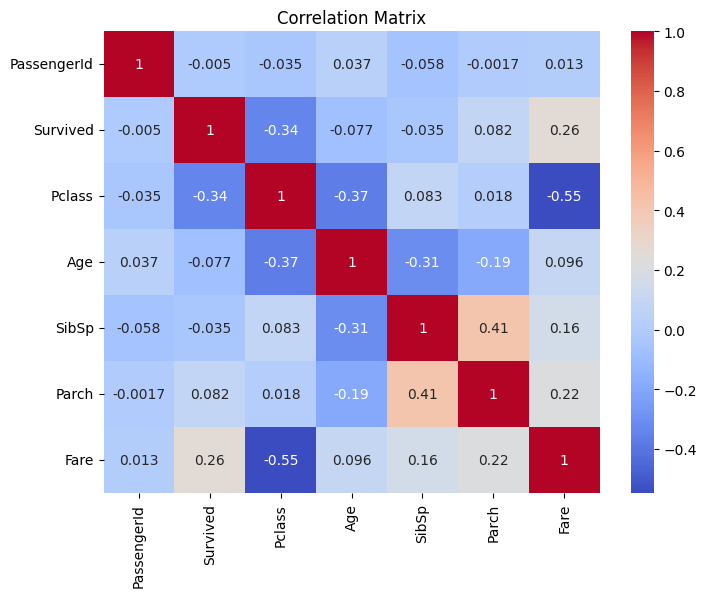

In [ ]:
# Heat Map

numeric_df = train_data.select_dtypes(include=['number'])
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Here, we add a heat map to show the correlation between each values. We also want to to look at the correlation between each value and survived. We can see Fare and Pclass have the strongest correlation with Survived. We can start from there.

The purpose of the exporatory data analysis is to allow us to look at the data that we can use to create a model that can predict who did survive versus those who did not. To do so, we need to look at multiple data points and see what we can use and what to ignore. We looked at the number of Nan/null for each value in the train_data data set, and we see most of the cabin values are missing. That is something we should remove. Also, we can look at the heat map above and see which values have a strong correlation with survived and start from there.

## 3. Change Features

In [ ]:
def add_custom_features(df):
    df = df.copy()

    # Drop unused
    df = df.drop(columns=["Cabin", "Ticket"], errors="ignore")

    # Title
    df['Title'] = df['Name'].str.extract(r',\s*([^\.]*)\s*\.', expand=False)
    df['Title'] = df['Title'].replace([
        'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev',
        'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

    # FamilySize and IsAlone
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # AgeGroup bins
    df['AgeGroup'] = pd.cut(df['Age'],
        bins=[0, 4, 12, 17, 29, 59, 120],
        labels=["Baby", "Child", "Teenager", "YoungAdult", "Adult", "Senior"]
    )

    df['FareTimesClass'] = df['Fare'] * df['Pclass']

    return df

feature_adder = FunctionTransformer(add_custom_features)
train_data = feature_adder.transform(train_data)

In this code, we want to add features to include the existing features we have. We added, FamilySize, IsAlone, FareTimesClass to the dataset.

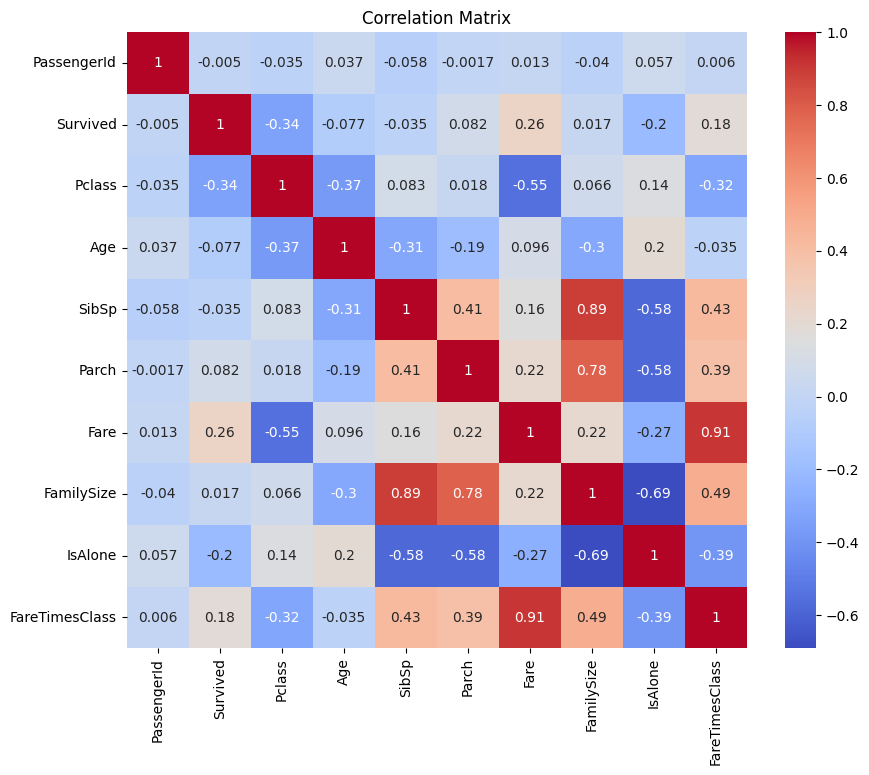

In [ ]:
numeric_df = train_data.select_dtypes(include=['number'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Another heat map with new data points

Add features

## 4. Preprocessing

In [ ]:
# Features to use
num_attribs = ["SibSp", "Parch", "Fare", "FamilySize", "IsAlone", "Age", 'FareTimesClass']
cat_attribs = ["Pclass", "Sex", "Embarked", "Title", "AgeGroup"]

# Numeric and categorical pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess_pipeline = Pipeline([
    ("add_features", feature_adder),
    ("transform", ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs)
    ]))
])

# Final pipeline with XGBoost
full_pipeline = Pipeline([
    ("feature_adder", FunctionTransformer(add_custom_features)),
    ("preprocessor", preprocess_pipeline),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])


This is the preprocessing part. We need to include preprocessing because we want to make sure empty data points do not affect training, encode categorical data to work with non-numerical data, and drop unnecessary data that could lead to overfitting. This will be applied to our GridSearchCV model to make our predictions.

## 5. Train, Test, Split

In [ ]:
X = train_data.drop("Survived", axis=1)
y = train_data["Survived"]
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42)

In this part, we want to run the train-test-split model validation so that we can feed the test data and see how it performs. This is needed to make sure we are not overfitting data and lead to poor predictions on new and unseen data. After this, we will apply this to our GridSearchCV model and make predictions.

## 6. Grid Search

In [ ]:
# Define parameter grid for XGBoost
param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.05, 0.1, 0.2],
    "clf__subsample": [0.8, 1.0]
}


We are defining the parameter grid for XGBoost. The purpose of this part is to control complexity, regularization and learning rate of the model. This means it can improve its capabilities to unseen data. We will also need these parameters to run our model.

## 7. Find accuracy

In [ ]:
# GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best model and accuracy
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Evaluate on validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy (best model): {val_accuracy:.4f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 1.0}
Best Cross-Validation Accuracy: 0.8398
Validation Accuracy (best model): 0.7937


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:50:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


This code will print the results and evaluate the validation set. We first use GridSearchCV by feeding the full pipeline to it. Then it is used to fit the data from the training data. Finally, we print the validation accuracy.

## 8. Submission CSV

In [ ]:
# Prepare the test set
X_test = test_data.copy()
passenger_ids = X_test["PassengerId"]

# Predict using the trained pipeline
predictions = best_model.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": predictions
})

# Save to CSV
submission.to_csv("submission.csv", index=False)

print("✅ Submission file 'submission.csv' created!")

✅ Submission file 'submission.csv' created!


Send the final results to the submission.csv file. This allows us to submit our results to Kaggle. Our score using this model is 0.7799.


---



## Older Code

### Support Vector Machine

In [ ]:
# from sklearn import svm

# clf = svm.SVC(kernel='poly')
# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# clf_scores = cross_val_score(clf, X_train, y_train, cv=10)
# clf_scores.mean()

np.float64(0.8249563046192259)

I first used a support vector machine using the exact same original code above. It gave me a score of 0.77511, just like the original.

### Support Vector Machine and GridSearchCV

In [ ]:
# from sklearn.preprocessing import FunctionTransformer

# def add_custom_features(df):
#     df = df.copy()

#     # Drop unused
#     df = df.drop(columns=["Cabin", "Ticket"], errors="ignore")

#     # Extract title from name
#     df['Title'] = df['Name'].str.extract(r',\s*([^\.]*)\s*\.', expand=False)
#     df['Title'] = df['Title'].replace([
#         'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev',
#         'Sir', 'Jonkheer', 'Dona'], 'Rare')
#     df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

#     # FamilySize and IsAlone
#     df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
#     df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

#     return df

# feature_adder = FunctionTransformer(add_custom_features)

Add custom features

In [ ]:
# # Preprocessing pipeline
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer

# # Features to use
# num_attribs = ["Age", "SibSp", "Parch", "Fare", "FamilySize", "IsAlone"]
# cat_attribs = ["Pclass", "Sex", "Embarked", "Title"]

# # Numeric and categorical pipelines
# num_pipeline = Pipeline([
#     ("imputer", SimpleImputer(strategy="median")),
#     ("scaler", StandardScaler())
# ])

# cat_pipeline = Pipeline([
#     ("imputer", SimpleImputer(strategy="most_frequent")),
#     ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
# ])

# # Full pipeline
# preprocess_pipeline = Pipeline([
#     ("add_features", feature_adder),
#     ("transform", ColumnTransformer([
#         ("num", num_pipeline, num_attribs),
#         ("cat", cat_pipeline, cat_attribs)
#     ]))
# ])

Preprocess pipeline

In [ ]:
# # Transform data
# X_train = preprocess_pipeline.fit_transform(train_data)
# y_train = train_data["Survived"]
# X_test = preprocess_pipeline.transform(test_data)

Now we feed our preprocessing pipeline data so that we can train our model and feed the transformed data

In [ ]:
# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'degree': [2, 3],  # Used only if kernel='poly'
#     'gamma': ['scale', 'auto']
# }

# grid_search = GridSearchCV(
#     estimator=svm.SVC(),
#     param_grid=param_grid,
#     cv=5,
#     scoring='accuracy',
#     verbose=2,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score:", grid_search.best_score_)

# # Final prediction
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # Save to CSV
# submission = test_data[["PassengerId"]].copy()
# submission["Survived"] = y_pred
# submission.to_csv("submission.csv", index=False)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Best cross-validation score: 0.837235578431988


We feed our data to our GridSearchCV model and print out our predictions and see how our model performed. This gave us a score of 0.77751.

### HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier, SVC

In [ ]:
# # Features to use
# num_attribs = ["SibSp", "Parch", "Fare", "FamilySize", "IsAlone", "Age", 'FarePerClass']
# cat_attribs = ["Pclass", "Sex", "Embarked", "Title", "AgeGroup"]

# from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier
# from sklearn.svm import SVC
# from sklearn.model_selection import cross_val_score

# svc_clf = SVC(C=1, kernel="rbf", gamma="scale", probability=True, random_state=42)
# rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
# gb_clf = HistGradientBoostingClassifier(random_state=42)

# voting_clf = VotingClassifier(
#     estimators=[
#         ('svc', svc_clf),
#         ('rf', rf_clf),
#         ('gb', gb_clf)
#     ],
#     voting='soft'  # uses predict_proba for better performance
# )

# voting_clf.fit(X_train, y_train)

# scores = cross_val_score(voting_clf, X_train, y_train, cv=5)
# print("Voting Classifier CV Accuracy:", scores.mean())

# y_pred = voting_clf.predict(X_test)
# # Save to CSV
# submission = test_data[["PassengerId"]].copy()
# submission["Survived"] = y_pred
# submission.to_csv("submission.csv", index=False)
# print("Your submission was successfully saved!")

Voting Classifier CV Accuracy: 0.8383780051471973
Your submission was successfully saved!


In this part, I decided to try out using a histogram gradient voting booster, random forest classifier, voting classifier, and support vector machine. Here, we are using the three classifiers to cross validate the accuracy and use the voting classifier to print out the accuracy. This gave me a Kaggle score of 0.76555.

In [ ]:
# from sklearn.ensemble import HistGradientBoostingClassifier

# gb_clf = HistGradientBoostingClassifier(random_state=42)
# gb_clf.fit(X_train, y_train)
# print("GB accuracy:", gb_clf.score(X_train, y_train))

# y_pred = gb_clf.predict(X_test)
# # Save to CSV

# submission = test_data[["PassengerId"]].copy()
# submission["Survived"] = y_pred
# submission.to_csv("submission.csv", index=False)
# print("Your submission was successfully saved!")

GB accuracy: 0.9506172839506173
Your submission was successfully saved!


For this part, I decided to use the histogram gradient boosting classifier only. The code is similar to the one above except we are only using the gradient booster classifier. We want to use this to see if the Kaggle score improves. However it did not because it dropped to 0.74162.